Test and demonstrate functionality from `spiral.py`

In [1]:
import sys,os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import importlib

In [2]:
# load file path information from the home directory
file_path_yml = os.path.join(os.environ["HOME"], ".ncar_config_derecho.yaml")
path_data = {}
with open(file_path_yml, "r") as r:
    path_data = yaml.safe_load(r)

In [3]:
dirP_str = os.path.join(
    path_data["ptv_collection_path"], "SpiralTorch", "python"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [31]:
from SpiralTorch import sparsa
from SpiralTorch import loss

In [28]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
# device = torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

dtype = torch.float64

Preparing to use device cpu


# Poisson Noise

First make some noisy Poisson data

In [129]:
x_axis = np.linspace(-10,10,64)
y_axis = np.linspace(-10,10,128)
x_ax_mesh,y_ax_mesh = np.meshgrid(x_axis,y_axis)

rec_count = 80

rec_x_position_arr = 20*(np.random.rand(rec_count)-0.5)
rec_y_position_arr = 20*(np.random.rand(rec_count)-0.5)
rec_x_arr = np.random.randn(rec_count)*5
rec_y_arr = np.random.randn(rec_count)*5
alpha_rec_arr = 100*np.random.rand(rec_count)

alpha_arr = np.zeros((y_axis.size,x_axis.size))

for idx in range(rec_count):
    rec_idx = np.where((y_ax_mesh >= rec_y_position_arr[idx]-rec_y_arr[idx]/2) & (y_ax_mesh <= rec_y_position_arr[idx]+rec_y_arr[idx]/2) & \
             (x_ax_mesh >= rec_x_position_arr[idx]-rec_x_arr[idx]/2) & (x_ax_mesh <= rec_x_position_arr[idx]+rec_x_arr[idx]/2))
    alpha_arr[rec_idx]+=alpha_rec_arr[idx]

alpha_arr+= 10

In [191]:
y_obs_fit = np.random.poisson(alpha_arr)
y_obs_val = np.random.poisson(alpha_arr)

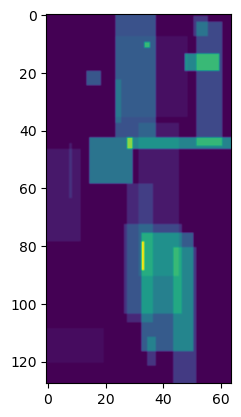

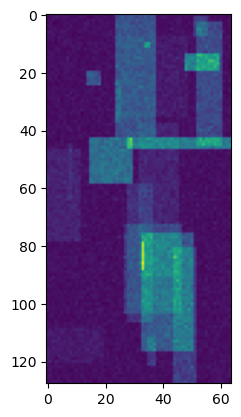

In [192]:
plt.figure()
plt.imshow(alpha_arr)

plt.figure()
plt.imshow(y_obs)

### Setup Sparsa subproblem

In [193]:
fista_ver_str = 'jit-fista'

In [194]:
def fwd_model_photons(**x):
    # really simple direct forward model
    return {'y_mean_est':torch.exp(x['backscatter'])}

In [195]:
y_obs_dct_lst = [
    {'counts':torch.tensor(y_obs,dtype=dtype,device=device),
    'shot_count':torch.ones((y_obs.shape[0],1),dtype=dtype,device=device)},
]
fwd_model_lst = [fwd_model_photons]

x0 = {'backscatter':torch.zeros(y_obs.shape,dtype=dtype,device=device)}

In [196]:
subprob = sparsa.sparsa_torch_autograd(device,dtype)
subprob.load_fit_parameters(x0,
                            y_obs_dct_lst,
                            fwd_model_lst,
                            'backscatter')
subprob.set_loss_fn(loss.pois_loss_fn)
subprob.set_fista(fista_ver_str) # use jit-fista
subprob.set_penalty_weight(2e1)
# subprob.set_alpha_min(1e4)
# subprob.set_alpha(1e10)

In [197]:
subprob.solve_sparsa_subprob()

'Maximum Iterations Exceeded'

In [198]:
x_est_arr = torch.exp(subprob.x).detach().numpy()

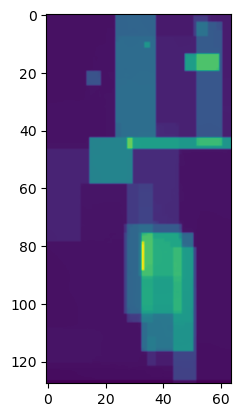

In [199]:
plt.figure()
plt.imshow(x_est_arr)

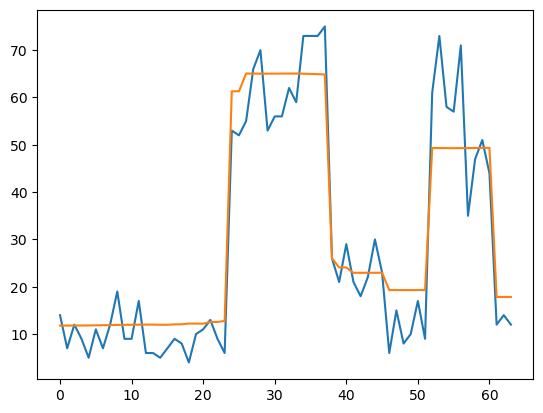

In [189]:
plt.figure()
plt.plot(y_obs_dct_lst[0]['counts'].detach().numpy()[40,:])
plt.plot(x_est_arr[40,:])

In [ ]:
y_val_dct_lst = [
    {'counts':torch.tensor(y_obs_val,dtype=dtype,device=device),
    'shot_count':torch.ones((y_obs_val.shape[0],1),dtype=dtype,device=device)},
]